This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/lyapunov.html).  I recommend having both windows open, side-by-side!


In [14]:
import sys
sys.path.append('/opt/drake/lib/python3.8/site-packages/')
sys.path.append('/home/aditya/Documents/projects/manipulation/')
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Markdown, display
from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)
from pydrake.examples.pendulum import PendulumParams
from pydrake.examples.van_der_pol import VanDerPolOscillator
from pydrake.symbolic import Polynomial

from underactuated import plot_2d_phase_portrait, running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()


# Common Lyapunov Analysis for Linear Systems

In [15]:
def common_lyapunov():
    A = []
    if (True):
        # Generate random stable matrices.
        num_states = 4
        num_systems = 2
        for i in range(num_systems):
            d = -np.random.rand(num_states,)
            v = np.random.randn(num_states, num_states)
            A.append(v.dot(np.diag(d).dot(np.linalg.inv(v))))
    else:
        # Example from lecture notes.
        A.append = np.array(((-1, .5), (-3, -1)))
        A.append = np.array(((-1, .1), (-10, -1)))
        # Interesting for 2D plotting (a two element parameterization of stable
        # linear systems).  Stable iff ab < 1.
        # a = randn;  ab = 2*rand - 1;  b=ab/a;
        # A{i} = [-1 a; b -1];

    # Create the optimization problem.
    prog = MathematicalProgram()

    # Construct an n-by-n positive semi-definite matrix as the decision
    # variables.
    num_states = A[0].shape[0]
    P = prog.NewSymmetricContinuousVariables(num_states, "P")
    prog.AddPositiveSemidefiniteConstraint(P - .01 * np.identity(num_states))

    # Add the common Lyapunov conditions.
    for i in range(len(A)):
        # yapf: disable
        prog.AddPositiveSemidefiniteConstraint(
            -A[i].transpose().dot(P) - P.dot(A[i]) - .01 * np.identity(num_states))
        # yapf: enable

    # Add an objective.
    prog.AddLinearCost(np.trace(P))

    # Run the optimization.
    result = Solve(prog)

    if result.is_success():
        P = result.GetSolution(P)
        print("eig(P) =" + str(np.linalg.eig(P)[0]))
        for i in range(len(A)):
            print("eig(Pdot" + str(i) + ") = " +
                str(np.linalg.eig(A[i].transpose().dot(P) + P.dot(A[i]))[0]))
    else:
        print("Could not find a common Lyapunov function.")
        print("This is expected to occur with some probability:  not all")
        print("random sets of stable matrices will have a common Lyapunov")
        print("function.")

common_lyapunov()

eig(P) =[2.11933157 0.01       0.02810639 0.08117988]
eig(Pdot0) = [-4.1162833  -0.05404512 -0.02867151 -0.01      ]
eig(Pdot1) = [-1.52117596 -0.04481243 -0.01       -0.01      ]


# Verifying a Lyapunov candidate via SOS

Successfully verified Lyapunov candidate


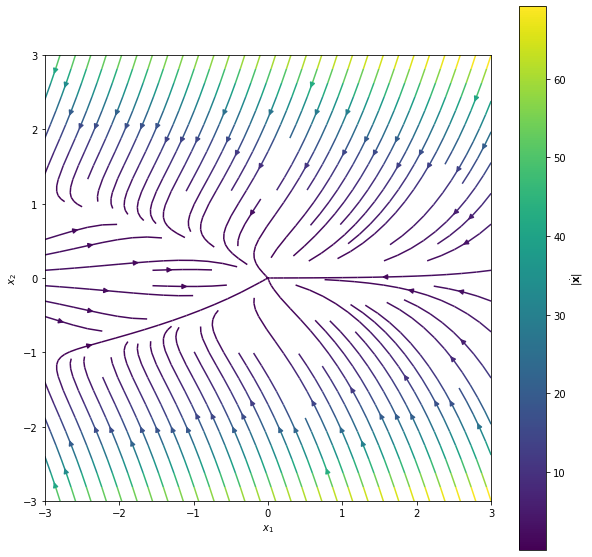

In [16]:
def sos_verify():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    f = [-x[0] - 2 * x[1]**2, -x[1] - x[0] * x[1] - 2 * x[1]**3]

    V = x[0]**2 + 2 * x[1]**2
    Vdot = V.Jacobian(x).dot(f)

    prog.AddSosConstraint(-Vdot)

    result = Solve(prog)
    assert result.is_success()

    sys = SymbolicVectorSystem(state=x, dynamics=f)
    fig, ax = plt.subplots(figsize=(10,10))
    plot_2d_phase_portrait(sys, (-3, 3), (-3, 3))
    print("Successfully verified Lyapunov candidate")

sos_verify()

# Searching for a Lyapunov function via SOS

In [17]:
def sos_optimize():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    f = [-x[0] - 2 * x[1]**2, -x[1] - x[0] * x[1] - 2 * x[1]**3]

    V = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
    print("Candidate:")
    display(Markdown("$V(x) = " + ToLatex(V) + "$"))
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]: 0}) == 0)
    prog.AddLinearConstraint(V.Substitute({x[0]: 1, x[1]: 0}) == 1)
    Vdot = V.Jacobian(x).dot(f)

    prog.AddSosConstraint(-Vdot)

    result = Solve(prog)
    assert result.is_success()

    print("Solution:")
    display(Markdown("$V(x) = " + ToLatex(
        Polynomial(result.GetSolution(V)).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))


sos_optimize()

Candidate:


$V(x) = (Symmetric_{2,2} + 2x_{0} x_{1} Symmetric_{1,0} + 2x_{0} Symmetric_{2,1} + x_{0}^{2} Symmetric_{1,1} + 2x_{1} Symmetric_{2,0} + x_{1}^{2} Symmetric_{0,0})$

Solution:


$V(x) = (1.000000x_{0}^{2} + 1.999999x_{1}^{2})$

# Region of attraction for the one-dimensional cubic system

In [18]:
def sos_roa():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(1, "x")

    # Define the dynamics and Lyapunov function.
    f = -x + x**3
    V = x.dot(x)
    Vdot = Jacobian([V], x).dot(f)[0]

    # Define the Lagrange multiplier.
    lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()

    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))

    result = Solve(prog)

    assert result.is_success(), "Optimization failed"

    print("Verified that " + str(V) + " < 1 is in the region of attraction.")

sos_roa()

Verified that pow(x(0), 2) < 1 is in the region of attraction.


In [7]:
def sos_roa2():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(1, "x")
    rho = prog.NewContinuousVariables(1, "rho")[0]

    # Define the dynamics and Lyapunov function.
    f = -x + x**3
    V = x.dot(x)
    Vdot = Jacobian([V], x).dot(f)[0]

    # Define the Lagrange multiplier.
    lambda_ = prog.NewContinuousVariables(1, "lambda")[0]

    prog.AddSosConstraint((V - rho) * x.dot(x) - lambda_ * Vdot)
    prog.AddLinearCost(-rho)

    result = Solve(prog)

    assert result.is_success()

    print("Verified that " + str(V) + " < " + str(result.GetSolution(rho)) +
        " is in the region of attraction.")

    assert np.fabs(result.GetSolution(rho) - 1) < 1e-5

sos_roa2()

Verified that pow(x(0), 2) < 1.0 is in the region of attraction.


# Region of Attraction codes in Drake

In [8]:
def roa():
    x = Variable("x")
    sys = SymbolicVectorSystem(state=[x], dynamics=[-x+x**3])
    context = sys.CreateDefaultContext()
    V = RegionOfAttraction(system=sys, context=context)

    print("Verified that " + str(V) + " < 1 is in the region of attraction.")

roa()

Verified that ((0.5 * pow(x(0), 2)) / 0.49999999999999978) < 1 is in the region of attraction.


# Time-reversed van der Pol Oscillator

We also use this example in the exercises at the end of the Lyapunov chapter, and work through all of the details of the formulation.  I highly recommend you try it out!

N.B. -- we know how to get much larger/tighter (inner) approximations of this RoA.  I will be implementing those ideas in drake's RegionOfAttraction method very soon.  Hopefully the region will be even bigger next time you try it.

In [9]:
def vdp_roa():
    x1 = Variable("x1")
    x2 = Variable("x2")
    sys = SymbolicVectorSystem(state=[x1, x2],
                               dynamics=[-x2, x1 + (x1 * x1 - 1) * x2])
    context = sys.CreateDefaultContext()
    V = RegionOfAttraction(system=sys, context=context)

    fig, ax = plt.subplots(figsize=(10,10))
    plot_2d_phase_portrait(sys, (-3, 3), (-3, 3))
    limit_cycle = VanDerPolOscillator.CalcLimitCycle()
    plt.plot(limit_cycle[0], limit_cycle[1], color='k', linewidth=3, label='Known ROA boundary')
    plt.legend(loc=1)
    plot_sublevelset_expression(ax, V)
    display(mpld3.display())

vdp_roa()

# Estimated regions of attraction need not be convex regions (in state space)

To demonstrate that, let's make a system with a known, non-convex region of attraction.  We'll do this by taking some interesting potential function $U(x) \in SOS$ and setting the dynamics to be $\dot{x} = (U(x)-1) \frac{\partial U}{\partial x}^T$, which has $U(x) <= 1$ as the region of attraction.  

Slightly more general is to write $\dot{x} = (U(x)-1) {\bf R}(\theta) \frac{\partial U}{\partial x}^T$, where ${\bf R}(\theta) = \begin{bmatrix} \cos\theta & \sin\theta \\ -\sin\theta & \cos\theta\end{bmatrix}$ is the 2D rotation matrix, and $\theta<\pi$ is a constant parameter (not a decision variable nor indeterminate), which still has the same region of attraction.

**Note: This example is (currently) broken when using Mosek as the SDP solver.**  The estimated region of attraction is actually outside the known region of attraction!  This is due to some subtle numerical issues in the solver.  I've left it in as honest and educational, but we are working to make the solver pre-processing more robust to examples like this.  See [Drake Issue #12876](https://github.com/RobotLocomotion/drake/issues/12876).

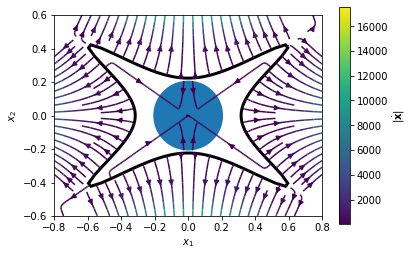

In [10]:
def star_convex():
    # Construct a non-convex 2D level set.
    x = np.array([Variable("x"), Variable("y")]).reshape((2,))
    A1 = np.array([[1, 2], [3, 4]])
    A2 = A1 @ np.array([[-1, 0], [0, 1]])  # mirror about y-axis
    U = (x.T.dot(A1.T.dot(A1.dot(x)))) * (x.T.dot(A2.T.dot(A2.dot(x))))

    fig, ax = plt.subplots()

    theta = 0.5;
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    dUdx = U.Jacobian(x)
    sys = SymbolicVectorSystem(state=x, dynamics=(U-1)* dUdx.T)
    context = sys.CreateDefaultContext()

    options = RegionOfAttractionOptions()
    options.lyapunov_candidate = x.dot(x)
    options.state_variables = x
    V = RegionOfAttraction(sys, context, options)
    plot_sublevelset_expression(ax, V)
    plot_sublevelset_expression(ax, U, 101, linewidth=3, fill=False);

    plot_2d_phase_portrait(sys, (-.8, .8), (-.6, .6))

if running_as_notebook:  # This test is flakey with some solvers.
    star_convex()

# Outer approximation for the cubic polynomial

In [11]:
def cubic_outer():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(1, "x")[0]
    f = -x + x**3

    # Make B(x) a free polynomial.
    B = prog.NewEvenDegreeFreePolynomial(Variables([x]), 4, "b").ToExpression()

    # Bdot(x) negative definite
    Bdot = B.Jacobian([x]).dot(f)[0]
    prog.AddSosConstraint(-Bdot + 0.1*x**2)

    # B(0) >= 0.1
    prog.AddLinearConstraint(B.Substitute({x: 0}) >= 0.1)

    # Construct W(x) as a SOS polynomial
    # Note: doing it manually to make the integration easier
    W = prog.NewEvenDegreeSosPolynomial(Variables([x]), 4)[0]
    We = W.ToExpression()

    # W(x) > B(x) + 1.0
    prog.AddSosConstraint(We - B - 1.0)

    # min \int_{-2}^2 W(x)dx
    prog.AddCost(W.Integrate(x, -2, 2).ToExpression())

    result = Solve(prog)

    assert result.is_success()

    Bsol = result.GetSolution(B)
    print(f"B = {Bsol}")
    Wsol = result.GetSolution(W)
    fig, ax = plt.subplots()
    xs = np.linspace(-2, 2, 51)
    fsols = [f.Evaluate({x: xi}) for xi in xs]
    Bsols = [Bsol.Evaluate({x: xi}) for xi in xs]
    Wsols = [Wsol.Evaluate({x: xi}) for xi in xs]
    ax.plot(xs, 0*xs, 'k')
    ax.plot(xs, fsols)[0].set_label('f(x)')
    ax.plot(xs, Bsols)[0].set_label('B(x)')
    ax.plot(xs, Wsols)[0].set_label('W(x)')
    plt.ylim(-2.5, 2.5)
    ax.legend()
    display(mpld3.display())

cubic_outer()

B = (0.1000000004672172 + 0.035299687669927443 * pow(x(0), 2) - 0.13295669101352608 * pow(x(0), 4))


# Global stability of the simple pendulum via SOS

Mechanical Energy = 
(4.9050000000000002 * (1 - c(0)) + 0.125 * pow(thetadot(0), 2))
V =
2.4395054818570228*1 + 0.12606196061448935*thetadot(0)^2 + -4.8790236897694896*c(0) + 2.4395182111018459*c(0)^2 + -1.5077272698054742e-06*s(0) + 0.076842107313013427*s(0) * thetadot(0) + 2.4654960298959656*s(0)^2


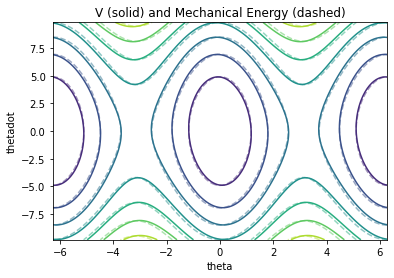

In [12]:
def global_pendulum():
    prog = MathematicalProgram()

    # Declare the "indeterminates", x.  These are the variables which define the
    # polynomials, but are NOT decision variables in the optimization.  We will
    # add constraints below that must hold FOR ALL x.
    s = prog.NewIndeterminates(1, "s")[0]
    c = prog.NewIndeterminates(1, "c")[0]
    thetadot = prog.NewIndeterminates(1, "thetadot")[0]
    # TODO(russt): bind the sugar methods so I can write
    #  x = prog.NewIndeterminates(["s", "c", "thetadot"])
    x = np.array([s, c, thetadot])

    # Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
    p = PendulumParams()
    f = [
        c * thetadot, -s * thetadot,
        (-p.damping() * thetadot - p.mass() * p.gravity() * p.length() * s) /
        (p.mass() * p.length() * p.length())
    ]

    # The fixed-point in this coordinate (because cos(0)=1).
    x0 = np.array([0, 1, 0])

    # Construct a polynomial V that contains all monomials with s,c,thetadot up
    # to degree 2.
    deg_V = 2
    V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

    # Add a constraint to enforce that V is strictly positive away from x0.
    # (Note that because our coordinate system is sine and cosine, V is also zero
    # at theta=2pi, etc).
    eps = 1e-4
    constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

    # Construct the polynomial which is the time derivative of V.
    Vdot = V.Jacobian(x).dot(f)

    # Construct a polynomial L representing the "Lagrange multiplier".
    deg_L = 2
    L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

    # Add a constraint that Vdot is strictly negative away from x0 (but make an
    # exception for the upright fixed point by multipling by s^2).
    constraint2 = prog.AddSosConstraint(-Vdot - L * (s**2 + c**2 - 1) - eps *
                                        (x - x0).dot(x - x0) * s**2)
    # TODO(russt): When V is the mechanical energy, Vdot=-b*thetadot^2, so I may not need all of the multipliers here.                  

    # Add V(0) = 0 constraint
    constraint3 = prog.AddLinearConstraint(
        V.Substitute({
            s: 0,
            c: 1,
            thetadot: 0
        }) == 0)

    # Add V(theta=pi) = mgl, just to set the scale.
    constraint4 = prog.AddLinearConstraint(
        V.Substitute({
            s: 1,
            c: 0,
            thetadot: 0
        }) == p.mass() * p.gravity() * p.length())

    # Call the solver.
    result = Solve(prog)
    assert result.is_success()

    # Note that I've added mgl to the potential energy (relative to the textbook),
    # so that it would be non-negative... like the Lyapunov function.
    mgl = p.mass() * p.gravity() * p.length()
    print("Mechanical Energy = ")
    print(.5 * p.mass() * p.length()**2 * thetadot**2 + mgl * (1 - c))

    print("V =")
    Vsol = Polynomial(result.GetSolution(V))
    print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))

    # Plot the results as contour plots.
    nq = 151
    nqd = 151
    q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
    qd = np.linspace(-2 * mgl, 2 * mgl, nqd)
    Q, QD = np.meshgrid(q, qd)
    Energy = .5 * p.mass() * p.length()**2 * QD**2 + mgl * (1 - np.cos(Q))
    Vplot = Q.copy()
    env = {s: 0., c: 1., thetadot: 0}
    for i in range(nq):
        for j in range(nqd):
            env[s] = np.sin(Q[i, j])
            env[c] = np.cos(Q[i, j])
            env[thetadot] = QD[i, j]
            Vplot[i, j] = Vsol.Evaluate(env)

    # plt.rc("text", usetex=True)
    fig, ax = plt.subplots()
    ax.contour(Q, QD, Vplot)
    ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
    ax.set_xlabel("theta")
    ax.set_ylabel("thetadot")
    ax.set_title("V (solid) and Mechanical Energy (dashed)")

global_pendulum()

# Verifying trigonometric polynomial systems in implicit form.

In order to achieve region of attraction analysis of general MultibodyPlant systems, we lean into the Drake's symbolic engine. Here is an example of the type of symbolic substitutions that go on behind the scenes in the `RegionOfAttraction` code.

In [13]:
from IPython.display import display, Math
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape


def PrintImplicitPolynomialDynamics(plant,
                                    context,
                                    sincos_indices):
    sym_plant = plant.ToSymbolic()
    sym_context = sym_plant.CreateDefaultContext()
    sym_context.SetTimeStateAndParametersFrom(context)
    sym_plant.FixInputPortsFrom(plant, context, sym_context)

    state = sym_context.get_continuous_state()
    derivatives = sym_context.Clone().get_mutable_continuous_state()

    q = MakeVectorVariable(state.num_q(), "q")
    v = MakeVectorVariable(state.num_v(), "v")
    qd = MakeVectorVariable(state.num_q(), "\dot{q}")
    vd = MakeVectorVariable(state.num_v(), "\dot{v}")

    state.SetFromVector(np.hstack((q, v)))
    derivatives.SetFromVector(np.hstack((qd, vd)))
    residual = sym_plant.CalcImplicitTimeDerivativesResidual(
        sym_context, derivatives)

    s = MakeVectorVariable(state.num_q(), "s")
    c = MakeVectorVariable(state.num_q(), "c")
    subs = {}
    for i in sincos_indices:
        subs[q[i]] = SinCos(s[i], c[i])
    dynamics = Substitute(residual, subs)

    display(Markdown("$"+ToLatex(dynamics, 2) + "= 0$"))


def TestPendulum():
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()
    plant.get_input_port().FixValue(context, [0])
    indices = [0]
    PrintImplicitPolynomialDynamics(plant, context, indices)

TestPendulum()

def TestAcrobot():
    plant = AcrobotPlant()
    context = plant.CreateDefaultContext()
    plant.get_input_port().FixValue(context, [0])
    indices = [0, 1]
    PrintImplicitPolynomialDynamics(plant, context, indices)

TestAcrobot()

def TestCartPole():
    plant = MultibodyPlant(0.0)
    Parser(plant).AddModelFromFile(FindResource('models/cartpole.urdf'))
    plant.Finalize()
    context = plant.CreateDefaultContext()
    plant.get_actuation_input_port().FixValue(context, [0])
    indices = [1]
    PrintImplicitPolynomialDynamics(plant, context, indices)

TestCartPole()

# Example w/ quaternions
def TestFloatingBaseBody():
    plant = MultibodyPlant(0.0)
    AddShape(plant, Box(1,2,3), "body", 1)
    plant.Finalize()
    context = plant.CreateDefaultContext()
    indices=[]
    PrintImplicitPolynomialDynamics(plant, context, indices)

TestFloatingBaseBody()

$\begin{bmatrix} ( - v_{0} + \dot{q}_{0}) \\ (\dot{v}_{0} - \frac{( - 0.10v_{0} - 4.91s_{0})}{0.25}) \end{bmatrix}= 0$

$\begin{bmatrix} ( - v_{0} + \dot{q}_{0}) \\ ( - v_{1} + \dot{q}_{1}) \\ (0.10v_{0} + 4.91s_{0} + 9.81(s_{0} + s_{0} c_{1} + s_{1} c_{0}) - 2v_{0} v_{1} s_{1} - v_{1}^{2} s_{1} + \dot{v}_{0} (2.66 + 2c_{1}) + \dot{v}_{1} (1.33 + c_{1})) \\ (0.10v_{1} + 1.33\dot{v}_{1} + 9.81(s_{0} c_{1} + s_{1} c_{0}) + v_{0}^{2} s_{1} + \dot{v}_{0} (1.33 + c_{1})) \end{bmatrix}= 0$

$\begin{bmatrix} ( - v_{0} + \dot{q}_{0}) \\ ( - v_{1} + \dot{q}_{1}) \\ (11\dot{v}_{0} - 0.50v_{1}^{2} s_{1} + 0.50\dot{v}_{1} c_{1}) \\ (0.25\dot{v}_{1} + 4.91s_{1} + 0.50\dot{v}_{0} c_{1}) \end{bmatrix}= 0$

$\begin{bmatrix} (\dot{q}_{0} + v_{0} \frac{q_{1}}{2} + v_{1} \frac{q_{2}}{2} + v_{2} \frac{q_{3}}{2}) \\ (\dot{q}_{1} - v_{0} \frac{q_{0}}{2} - v_{1} \frac{q_{3}}{2} + v_{2} \frac{q_{2}}{2}) \\ (\dot{q}_{2} + v_{0} \frac{q_{3}}{2} - v_{1} \frac{q_{0}}{2} - v_{2} \frac{q_{1}}{2}) \\ (\dot{q}_{3} - v_{0} \frac{q_{2}}{2} + v_{1} \frac{q_{1}}{2} - v_{2} \frac{q_{0}}{2}) \\ ( - v_{3} + \dot{q}_{4}) \\ ( - v_{4} + \dot{q}_{5}) \\ ( - v_{5} + \dot{q}_{6}) \\ (v_{1} (v_{0} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) ( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{1} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{2} (0.42 + 0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2})) - v_{2} (v_{0} (0.42( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{1} (0.42 + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} + 0.42(1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2}) + v_{2} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}))) + \dot{v}_{0} (1.50 - 0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.42(1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2}) + \dot{v}_{1} (0.42( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + \dot{v}_{2} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) ( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}))) \\ ( - v_{0} (v_{0} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) ( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{1} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{2} (0.42 + 0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2})) + v_{2} (v_{0} (1.50 - 0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.42(1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2}) + v_{1} (0.42( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{2} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) ( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}))) + \dot{v}_{0} (0.42( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + \dot{v}_{1} (0.42 + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} + 0.42(1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2}) + \dot{v}_{2} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}))) \\ (v_{0} (v_{0} (0.42( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{1} (0.42 + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} + 0.42(1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2}) + v_{2} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}))) - v_{1} (v_{0} (1.50 - 0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} - 0.42(1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2}) + v_{1} (0.42( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67(q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + v_{2} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) ( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}))) + \dot{v}_{0} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) ( - q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{2} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + \dot{v}_{1} (0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (1 - q_{1} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} - q_{3} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})}) (q_{0} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})) + \dot{v}_{2} (0.42 + 0.42(q_{0} \frac{2 q_{1}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{2} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2} + 0.67( - q_{0} \frac{2 q_{2}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})} + q_{1} \frac{2 q_{3}}{(q_{0}^{2} + q_{1}^{2} + q_{2}^{2} + q_{3}^{2})})^{2})) \\ \dot{v}_{3} \\ \dot{v}_{4} \\ (9.81 + \dot{v}_{5}) \end{bmatrix}= 0$